In [ ]:
!pip install transformers

In [ ]:
!unzip ner.zip

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers import BertForTokenClassification, BertTokenizer

import pandas as pd
import numpy as np

# Data preparation

In [6]:
df = pd.read_csv('ner.csv', encoding = "ISO-8859-1", error_bad_lines=False)
df = df.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma',
              'next-next-pos', 'next-next-shape',
              'next-next-word', 'next-pos', 'next-shape',
              'next-word', 'prev-iob', 'prev-lemma',
              'prev-pos', 'prev-prev-iob', 'prev-prev-lemma',
              'prev-prev-pos', 'prev-prev-shape', 'prev-prev-word',
              'prev-shape', 'prev-word', 'shape'], axis=1)
df['tag'].fillna('O', inplace=True)
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 281837: expected 25 fields, saw 34\n'


,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O
...,...,...,...,...
1050790,PRP,47959.0,they,O
1050791,VBD,47959.0,responded,O
1050792,TO,47959.0,to,O
1050793,DT,47959.0,the,O


In [7]:
tags_vals = list(set(df["tag"].values))
tag2idx = {t: i for i, t in enumerate(tags_vals)}
tag2idx

{'B-art': 14,
 'B-eve': 15,
 'B-geo': 9,
 'B-gpe': 3,
 'B-nat': 1,
 'B-org': 10,
 'B-per': 11,
 'B-tim': 13,
 'I-art': 6,
 'I-eve': 0,
 'I-geo': 4,
 'I-gpe': 5,
 'I-nat': 2,
 'I-org': 12,
 'I-per': 7,
 'I-tim': 8,
 'O': 16}

In [8]:
agg_func = lambda vals: ' '.join(list(vals['word']))
sentences = list(df.groupby('sentence_idx').apply(agg_func).values)

agg_func = lambda vals: [tag for tag in list(vals['tag'])]
labels = list(df.groupby('sentence_idx').apply(agg_func).values)

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, sentences, max_len, labels):
        self.len = len(sentences)
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.max_len = max_len
        self.labels = labels

    def __getitem__(self, index):
        sentence = str(self.sentences[index])
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        label = self.labels[index]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'tags': torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return self.len

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
train_size = int(len(sentences) * 0.9)
idx = np.arange(len(sentences), dtype=int)
np.random.shuffle(idx)

train_sentences = [sentences[idx[i]] for i in range(train_size)]
train_labels = [labels[idx[i]] for i in range(train_size)]

test_sentences = [sentences[idx[i]] for i in range(train_size + 1, len(sentences))]
test_labels = [labels[idx[i]] for i in range(train_size + 1, len(sentences))]

from keras.preprocessing.sequence import pad_sequences
train_labels = pad_sequences([[tag2idx.get(l) for l in lab] for lab in train_labels],
                               maxlen=60, value=tag2idx["O"], padding="post",
                               dtype="long", truncating="post")

test_labels = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                               maxlen=60, value=tag2idx["O"], padding="post",
                               dtype="long", truncating="post")

train_set = CustomDataset(tokenizer, train_sentences, 60, train_labels)
test_set = CustomDataset(tokenizer, test_sentences, 60, test_labels)

In [13]:
train_dloader = torch.utils.data.DataLoader(train_set, shuffle=True,
                                            batch_size=32)

test_dloader = torch.utils.data.DataLoader(test_set, shuffle=True,
                                           batch_size=16)

# Training

In [14]:
class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()

        self.classif = BertForTokenClassification.from_pretrained('bert-base-cased',
                                                                  num_labels=len(tag2idx))

    def forward(self, ids, mask, labels):
        return self.classif(ids, mask, labels=labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifier().to(device)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [15]:
def train(epoch):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

    for i, input in enumerate(train_dloader):
        ids = input['ids'].to(device)
        mask = input['mask'].to(device)
        tags = input['tags'].to(device)

        optimizer.zero_grad()
        loss = model(ids, mask, labels=tags)[0]
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch} Loss = {loss.detach().item()}')

In [16]:
for epoch in range(5):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 0 Loss = 0.14407594501972198
Epoch 1 Loss = 0.13916920125484467
Epoch 2 Loss = 0.048336829990148544
Epoch 3 Loss = 0.06576760113239288
Epoch 4 Loss = 0.09645240753889084


# Validation

In [ ]:
!pip install seqeval

In [18]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

lens = []
for i in range(len(test_labels)):
    lens.append(len(test_labels[i]))

def separate_tags(tags):
    offs = 0
    tags_sep = []
    for i in range(len(test_labels)):
        tags_sep.append(tags[offs: offs + lens[i]])
        offs += lens[i]

    return tags_sep

In [19]:
model.eval()
eval_loss = 0; eval_accuracy = 0
n_correct = 0; n_wrong = 0; total = 0
predictions , true_labels = [], []
nb_eval_steps, nb_eval_examples = 0, 0
with torch.no_grad():
    for _, data in enumerate(test_dloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['tags'].to(device, dtype = torch.long)

        output = model(ids, mask, labels=targets)
        loss, logits = output[:2]
        logits = logits.detach().cpu().numpy()
        label_ids = targets.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        accuracy = flat_accuracy(logits, label_ids)
        eval_loss += loss.mean().item()
        eval_accuracy += accuracy
        nb_eval_examples += ids.size(0)
        nb_eval_steps += 1
        
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]

    pred_tags_sep = separate_tags(pred_tags)
    valid_tags_sep = separate_tags(valid_tags)
    print("F1-Score: {}".format(f1_score(pred_tags_sep, valid_tags_sep)))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation loss: 0.13812554217875003
Validation Accuracy: 0.9437631118881121
F1-Score: 0.5789993055809364


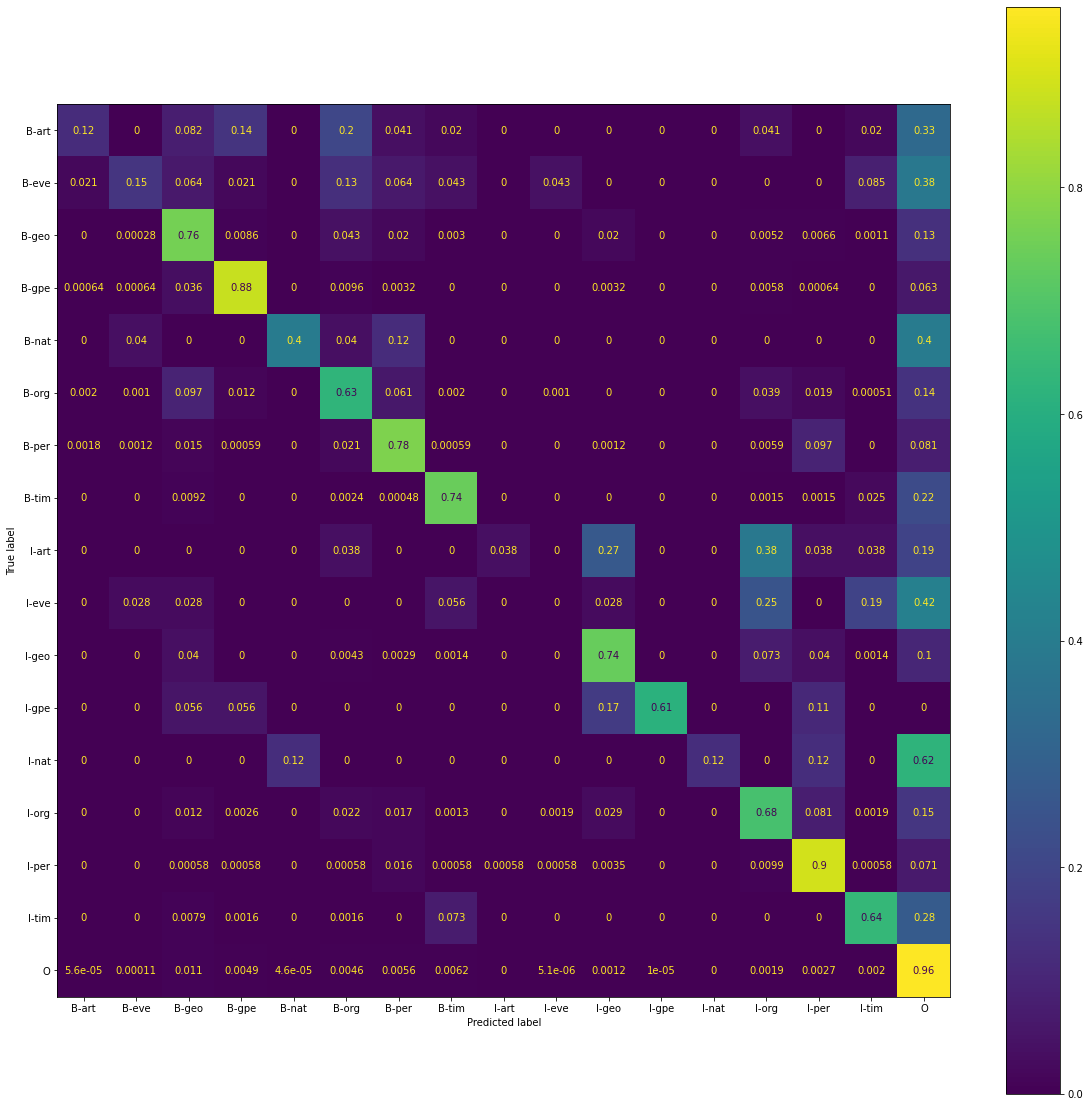

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ConfusionMatrixDisplay.from_predictions(valid_tags, pred_tags, ax=ax, normalize='true')